Considers each research questions and hypotheses studied in [1] and generates the results in [1]

The research questions and hypotheses are listed as follows:

* RQ1 How do the interlocutors use task specific referents? Does this link to task success?
    * H1.1: Task specific referents become routine earlier for more successful teams.
    * H1.2: When (a) task specific referents become routine and (b) their routines are primed, they are more likely to be surrounded by hesitation phenomena for more successful teams.

* RQ2 How do the interlocutors follow up the use of task specific referents with actions? Does this link to task success?
    * H2.1: Instructions are more likely to be followed by the corresponding actions earlier in the dialogue for more successful teams.
    * H2.2: When instructions are followed by a corresponding or a different action, the action is more likely to be surrounded by information management phenomena for more successful teams.


[1] U. Norman\*, T. Dinkar\*, B. Bruno, P. Dillenbourg, and C. Clavel, "Studying Alignment in Spontaneous Speech via Automatic Methods: How Do Children Use Task-specific Referents to Succeed in a Collaborative Learning Activity?," under review, 2021.

In [1]:
import math
import pickle

import pathlib as pl
import pandas as pd
import numpy as np

import scipy  # to perform Mann-Whitney U Test
from cliffsDelta import cliffsDelta  # to estimate effect size by Cliff's Delta

from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

import seaborn as sns

from read_utils import read_tables
from match_utils import Instruction, \
    Do, Match, Mismatch, Nonmatch

In [2]:
sns.set_theme(style='whitegrid')

## Define paths.

In [3]:
# Inputs.
processed_data_dir = pl.Path('../processed_data')
log_features_file = processed_data_dir.joinpath(
    'log_features/justhink19_log_features_task_level.csv')
# Also log features at attempt and turn levels, for descriptive statistics.
attempt_features_file = processed_data_dir.joinpath(
    'log_features/justhink19_log_features_attempt_level.csv')
turn_features_file = processed_data_dir.joinpath(
    'log_features/justhink19_log_features_turn_level.csv')

learning_file = processed_data_dir.joinpath(
    'learning_features/justhink19_learning_features.csv')

annot_corpus_dir = processed_data_dir.joinpath('annotated_corpus')
annot_corpus_pickle_file = annot_corpus_dir.joinpath(
    'justhing19_annotated_corpus.pickle')

routines_dir = processed_data_dir.joinpath('routines')
tokens_dir = processed_data_dir.joinpath('tokens')

# Outputs.
plots_dir = pl.Path('../figures')


# Create output directories if they do not exist.
for folder in [plots_dir]:
    if not folder.exists():
        folder.mkdir(parents=True)

## Load data.

### Read learning data.

In [4]:
learning_df = pd.read_csv(learning_file, index_col='team_no')

# learning_df

### Read task features data (at the team level).

In [5]:
task_df = pd.read_csv(log_features_file, index_col='team_no')

# task_df

### Read task features data (at the attempt and turn level).
These are only used to compute descriptive statistics like duration of a turn.

In [6]:
attempt_df = pd.read_csv(attempt_features_file, index_col='team_no')
turn_df = pd.read_csv(turn_features_file, index_col='team_no')

### Read annotated corpus (of dialogue and actions).

In [7]:
with annot_corpus_pickle_file.open('rb') as handle:
    corpus_dfs = pickle.load(handle)

### Read routine tables.

In [8]:
routine_dfs = read_tables(routines_dir, form='routine')

# routines_dfs[7].head()

Reading routine files from ../processed_data/routines.
routine 10 files found.
File justhink19_routines_07 belongs to team  7
File justhink19_routines_08 belongs to team  8
File justhink19_routines_09 belongs to team  9
File justhink19_routines_10 belongs to team 10
File justhink19_routines_11 belongs to team 11
File justhink19_routines_17 belongs to team 17
File justhink19_routines_18 belongs to team 18
File justhink19_routines_20 belongs to team 20
File justhink19_routines_28 belongs to team 28
File justhink19_routines_47 belongs to team 47


In [9]:
tokens_dfs = read_tables(tokens_dir, form='transcript')

tokens_dfs[7].head()

Reading transcript files from ../processed_data/tokens.
transcript 10 files found.
File justhink19_tokens_07 belongs to team  7
File justhink19_tokens_08 belongs to team  8
File justhink19_tokens_09 belongs to team  9
File justhink19_tokens_10 belongs to team 10
File justhink19_tokens_11 belongs to team 11
File justhink19_tokens_17 belongs to team 17
File justhink19_tokens_18 belongs to team 18
File justhink19_tokens_20 belongs to team 20
File justhink19_tokens_28 belongs to team 28
File justhink19_tokens_47 belongs to team 47
Transcript of  7 has 3287 utterances
Transcript of  8 has 3464 utterances
Transcript of  9 has 4536 utterances
Transcript of 10 has 2149 utterances
Transcript of 11 has 3092 utterances
Transcript of 17 has 1762 utterances
Transcript of 18 has 1446 utterances
Transcript of 20 has 2533 utterances
Transcript of 28 has 1816 utterances
Transcript of 47 has 2331 utterances


,team_no,utterance_no,token_no,start,end,interlocutor,utterance,token
0,7,0,0,42.525,43.004,A,okay .,okay
1,7,0,1,42.525,43.004,A,okay .,.
2,7,1,2,47.732,48.615,A,i am doing this .,i
3,7,1,3,47.732,48.615,A,i am doing this .,am
4,7,1,4,47.732,48.615,A,i am doing this .,doing


## Construct task success tables.

### Prepare a learning outcomes table.

In [10]:
df = learning_df[['RLG', 'A_pretest', 'A_posttest', 'B_pretest', 'B_posttest']].copy()
df = df[df.index.isin(corpus_dfs.keys())]
df.insert(0, 'learn (%)', 100*df['RLG'])
df = df.drop(['RLG'], axis=1)
df.index.name = 'Team No'
for prefix in ['pretest', 'posttest']:
    df['{}s'.format(prefix)] = [
        '{:3.0f},{:3.0f}'.format(
            100*df.loc[t]['A_{}'.format(prefix)],
            100*df.loc[t]['B_{}'.format(prefix)])
        for t in df.index]
df = df[['learn (%)', 'pretests', 'posttests']]
learn_df = df.T
learn_df

Team No,7,8,9,10,11,17,18,20,28,47
learn (%),14.2857,-8.75,22.5,36.6667,36.6667,25,-56.25,-52.0833,0,-12.6984
pretests,"70, 30","50, 80","50, 60","40, 50","70, 50","40, 40","40, 80","80, 30","100, 60","90, 70"
posttests,"70, 50","60, 50","60, 70","60, 70","80, 70","50, 60","10, 50","50, 10","100, 60","80, 60"


### Prepare a task performance table.

In [11]:
corpus_dfs.keys()

dict_keys([7, 8, 9, 10, 11, 17, 18, 20, 28, 47])

In [12]:
df = task_df[['min_error']]
df = df[df.index.isin(corpus_dfs.keys())]
df['error (%)'] = 100 * df['min_error']
df = df.drop(['min_error'], axis=1)
perf_df = df.T
perf_df

team_no,7,8,9,10,11,17,18,20,28,47
error (%),13.636364,13.636364,4.545455,13.636364,4.545455,0.0,18.181818,0.0,0.0,13.636364


### Prepare sorting orders.

In [13]:
df = learn_df.T.sort_values('learn (%)', ascending=False)
learn_order = [str(t) for t in df.index]
learn_seps = ['28', '8']
df, learn_order, learn_seps

(        learn (%) pretests posttests
 Team No                             
 10        36.6667   40, 50    60, 70
 11        36.6667   70, 50    80, 70
 17             25   40, 40    50, 60
 9            22.5   50, 60    60, 70
 7         14.2857   70, 30    70, 50
 28              0  100, 60   100, 60
 8           -8.75   50, 80    60, 50
 47       -12.6984   90, 70    80, 60
 20       -52.0833   80, 30    50, 10
 18         -56.25   40, 80    10, 50,
 ['10', '11', '17', '9', '7', '28', '8', '47', '20', '18'],
 ['28', '8'])

In [14]:
df = perf_df.T.sort_values(['error (%)'])
perf_order = [str(t) for t in df.index]
perf_seps = ['28']
df, perf_order, perf_seps

(         error (%)
 team_no           
 17        0.000000
 20        0.000000
 28        0.000000
 9         4.545455
 11        4.545455
 7        13.636364
 8        13.636364
 10       13.636364
 47       13.636364
 18       18.181818,
 ['17', '20', '28', '9', '11', '7', '8', '10', '47', '18'],
 ['28'])

In [15]:
l = [28, 20, 17, 11, 9, 47, 10, 8, 7, 18]
# Order first by performance and then by duration (for the ties).
l = [28, 17, 20, 11, 9, 47, 10, 8, 7, 18]
l = [str(t) for t in l]
perf_order = l
perf_seps = ['20']
perf_order

['28', '17', '20', '11', '9', '47', '10', '8', '7', '18']

## Override utterance numbers in the corpus for relinking with the routines.

In [16]:
for team_no, df in corpus_dfs.items():
    
    df['utterance_no'] = -1
    
    cond = df.subject.isin(['A', 'B']) & df.verb.isin(['says'])
    df.loc[cond, 'utterance_no'] = range(len(df[cond]))
    
    corpus_dfs[team_no] = df

## Do additional annotations.

### Annotate the corpora with start and end times scaled to unit interval. 

In [17]:
for team_no, df in corpus_dfs.items():
    duration = df.iloc[-1]['end']
    print('{:2d}: {:.1f} mins'.format(team_no, duration/60))
    df['scaled_start'] = df['start'] / duration
    df['scaled_end'] = df['end'] / duration

 7: 26.4 mins
 8: 26.2 mins
 9: 36.0 mins
10: 23.1 mins
11: 26.4 mins
17: 17.9 mins
18: 30.6 mins
20: 19.3 mins
28: 11.2 mins
47: 19.6 mins


### Annotate the corpora with utterance positions scaled to unit interval. 

In [18]:
for team_no, df in corpus_dfs.items():
    # Utterances are zero-based numbered (first utterance has number 0).
    n_utterances = max(df['utterance_no']) + 1

    df['scaled_utterance_no'] = [(no + 1) / n_utterances if no != -1 else -1
                                 for no in df['utterance_no']]

### Annotate the corpora with error values upon submission.

In [19]:
def cost(x):
    '''the sum of the edge costs of the submitted solution'''
    submits = x[x['verb'].isin(['submits'])]
    if len(submits) > 0:
        return int(submits['object'].iloc[-1].split()[0].split('=')[-1])
    else:
        return np.nan
    
def error(x, opt_cost=22):
    '''relative error, i.e. absolute error divided by the optimal cost'''
    return 1.0 * (cost(x) - opt_cost) / opt_cost

for team_no, df in corpus_dfs.items():
    df.groupby('attempt_no')
    df['cost'] = df.groupby(df.index).apply(cost)
    df['error'] = df.groupby(df.index).apply(error)

### Annotate the routines with establishment and priming positions.

In [20]:
def get_priming_utterance_no(df, num_utterances):
    return [(row['utterances'][0]+1) / num_utterances
            for i, row in df.iterrows()]


# Annotate routine tables with establishment and priming position and times.
# Normalise/scale as a fraction of the total number of utterances for comparison.
for team_no, df in routine_dfs.items():
    corpus_df = corpus_dfs[team_no]
    df['team_no'] = team_no

    # Utterances are zero-based numbered (first utterance has number 0).
    n_utterances = max(corpus_df['utterance_no']) + 1
    print(team_no, n_utterances)

    # Retrieve the total duration.
    duration = corpus_df.iloc[-1]['end']

    # Annotate the establishment position (i.e. utterance no).
    df['establish_no'] = df['Establishment turn']
    # Annotate the establishment time (i.e. utterance end time).
    df['establish_time'] = [corpus_df[corpus_df['utterance_no'] == i].iloc[0]['end']
                            for i in df['establish_no']]
    # Annotate establishment position and time scaled to unit interval.
    df['scaled_establish_no'] = (df['establish_no'] + 1) / n_utterances
    df['scaled_establish_time'] = df['establish_time'] / duration

    # Annotate the priming position (i.e. utterance no).
    df['priming_no'] = [ll[0] for ll in df['utterances']]
    # Annotate the establishment time (i.e. utterance end time).
    df['priming_time'] = [corpus_df[corpus_df['utterance_no'] == i].iloc[0]['end']
                          for i in df['priming_no']]
    # Annotate establishment position and time scaled to unit interval.
    df['scaled_priming_no'] = (df['priming_no'] + 1) / n_utterances
    df['scaled_priming_time'] = df['priming_time'] / duration

7 608
8 624
9 773
10 431
11 540
17 297
18 331
20 494
28 334
47 355


### Split matches, mismatches and non-matches into columns.

In [21]:
# flatten a bit
for team_no, df in corpus_dfs.items():
    df['n_instructions'] = df.instructions.apply(len)
    matching = df.matching.apply(
        lambda x: [a for a in x if isinstance(a, Do)])
    df['do'] = matching.apply(lambda x: x[0] if len(x) > 0 else None)

    matching = df.matching.apply(lambda x: [a for a in x if isinstance(a, Match)])
    df['match'] = matching.apply(lambda x: x[0] if len(x) > 0 else None)
    df['is_match'] =  df['match'].notna()

    matching = df.matching.apply(lambda x: [a for a in x if isinstance(a, Mismatch)])
    df['mismatch'] = matching.apply(lambda x: x[0] if len(x) > 0 else None)
    df['is_mismatch'] =  df['mismatch'].notna()
    
    df['is_match_or_mismatch']  = df.is_match | df.is_mismatch
    
    matching = df.matching.apply(lambda x: [a for a in x if isinstance(a, Nonmatch)])
    df['nonmatch'] = matching.apply(lambda x: x[0] if len(x) > 0 else None)

In [22]:
# corpus_dfs[7]

## Construct helper tables.

### Merge all of the corpus into one table.

In [23]:
l = [corpus_dfs[k]  for k in sorted(corpus_dfs)]
all_corpus_df = pd.concat(l, ignore_index=True)
all_corpus_df['team_no'] = all_corpus_df['team_no'].astype(str)

### Merge all of the routine tables into one table.

In [24]:
l = [routine_dfs[k] for k in sorted(routine_dfs)]
all_routines_df = pd.concat(l, ignore_index=True)
all_routines_df['team_no'] = all_routines_df['team_no'].astype(str)

## Print number of utterances, tokens and duration.

In [25]:
d = {
    'team_no': [],
    'num_tokens': [],
    'num_utterances': [],
    'duration (secs)': [],
}
for team_no, tokens_df in tokens_dfs.items():
    corpus_df = corpus_dfs[team_no]
    d['team_no'].append(team_no)
    d['num_tokens'].append(max(tokens_df['token_no'])+1)
    d['num_utterances'].append(max(tokens_df['utterance_no'])+1)
    d['duration (secs)'].append(corpus_df.iloc[-1]['end'])

df = pd.DataFrame.from_dict(d, orient='index').T

cols = ['team_no', 'num_tokens', 'num_utterances']
for c in cols:
    df[c] = df[c].astype(int)
df['team_no'] = df['team_no'].astype(str)

df.set_index('team_no', inplace=True)
df = df.loc[perf_order]
df['duration (mins)'] = df['duration (secs)'] / 60
counts_df = df.copy()
counts_df

,num_tokens,num_utterances,duration (secs),duration (mins)
team_no,,,,
28,1816,334,670.087,11.168117
17,1762,297,1076.721,17.945350
20,2533,494,1156.613,19.276883
11,3092,540,1586.006,26.433433
9,4536,773,2160.630,36.010500
47,2331,355,1178.847,19.647450
10,2149,431,1384.955,23.082583
8,3464,624,1570.423,26.173717
7,3287,608,1581.443,26.357383


## Construct descriptive statistics table for the transcribed teams.

In [26]:
df = counts_df.copy()
df['num_attempts'] = [task_df.loc[int(t), 'num_attempt'] for t in df.index]
df['num_turns'] = [task_df.loc[int(t), 'num_turn'] for t in df.index]

l = ['mean', 'std', 'min', 'max']
df = df.describe().T[l].T
df

,num_tokens,num_utterances,duration (secs),duration (mins),num_attempts,num_turns
mean,2641.600000,478.700000,1420.154800,23.669247,9.400000,50.400000
std,949.864692,156.978449,422.513096,7.041885,4.742245,21.396781
min,1446.000000,297.000000,670.087000,11.168117,4.000000,28.000000
max,4536.000000,773.000000,2160.630000,36.010500,19.000000,98.000000


In [27]:
# Attempts that are not submitted (via intervention -> error is None) are dropped.
submitted_attempts = attempt_df.dropna().loc[counts_df.index.astype(int)]

turns = turn_df.loc[counts_df.index.astype(int)]
# Filter for only the turns with two edit actions.
# Since a team can start a turn but not be able to finish it (via intervention).
turns = turns[turns.num_edit == 2]

In [28]:
df['attempt_duration (secs)'] = submitted_attempts['duration'].agg(l)
df['attempt_duration (min)'] = df['attempt_duration (secs)'] / 60

In [29]:
num_tokens = tokens_df.groupby('utterance_no').apply(len)
df['num_tokens_per_utterance'] = num_tokens.agg(l)

In [30]:
df['turn_duration (secs)'] = turns['duration'].agg(l)

In [31]:
df.T

,mean,std,min,max
num_tokens,2641.600000,949.864692,1446.000000,4536.000000
num_utterances,478.700000,156.978449,297.000000,773.000000
duration (secs),1420.154800,422.513096,670.087000,2160.630000
duration (mins),23.669247,7.041885,11.168117,36.010500
num_attempts,9.400000,4.742245,4.000000,19.000000
num_turns,50.400000,21.396781,28.000000,98.000000
attempt_duration (secs),153.411609,139.831531,40.820000,766.310000
attempt_duration (min),2.556860,2.330526,0.680333,12.771833
num_tokens_per_utterance,6.566197,5.352330,1.000000,32.000000
turn_duration (secs),24.969746,30.327900,1.137000,240.198000


### Mark the routines that are established in the common time interval.

In [32]:
df = all_routines_df.copy()
common_duration = counts_df['duration (secs)'].min()
df['in_common_time'] = df.establish_time <= common_duration
all_routines_df = df

common_duration / 60

11.168116666666666

# RQ1: How do the interlocutors use task specific referents? Does this link to task success?

## H1.1: Task specific referents become routine earlier for more successful teams.

### Compute mean of medians and SD (and mean).

In [33]:
def compute_combined_mean_median_sd(df, of, by='team_no'):
   
    # Compute combined mean, median and SD.
    A = [np.array(l) for l in (df.groupby(by)[of].apply(list))]
    
    N = float(sum([i.size for i in A]))
    mean_ = sum([i.sum() for i in A])/N
    std_ = np.sqrt(sum([((i-mean_)**2).sum() for i in A])/N)
    print('combined mean = {:.2%} , combined SD = {:.1%}'.format(mean_, std_))

    medians = [np.median(i) for i in A]
    mean_medians = np.mean(medians)
    print('mean of the medians = {:.1%}'.format(mean_medians))
    
    d['team_no'].append(team_no)
    

of = 'scaled_establish_time'
compute_combined_mean_median_sd(all_routines_df, of=of)

combined mean = 60.99% , combined SD = 22.2%
mean of the medians = 63.0%


### Check Spearman's correlation with task performance.

In [34]:
l = list()

def compute_quartiles(grouped, prefix=''):
    df = grouped.agg(
        [np.median,
         lambda x: np.percentile(x, q=25),
         lambda x: np.percentile(x, q=75)])
    df.columns = ['{}{}'.format(prefix, c) for c in ['median', 'Q1', 'Q3']]
    df.index = df.index.astype(int)
    return df

# In common time establishments.
df = all_routines_df.copy()
df = df[df.in_common_time]
grouped = df.groupby('team_no')['establish_time']
df = compute_quartiles(grouped, 'in_common_')
l.append(df)

# All establishments, scaled and absolute time.
for prefix in ['', 'scaled_']:
    grouped = all_routines_df.groupby(
        'team_no')['{}establish_time'.format(prefix)]
    df = compute_quartiles(grouped, prefix)
    l.append(df)
    
result_df = pd.concat([*l, perf_df.T, learn_df.T], axis=1)
result_df.sort_values('error (%)')

,in_common_median,in_common_Q1,in_common_Q3,median,Q1,Q3,scaled_median,scaled_Q1,scaled_Q3,error (%),learn (%),pretests,posttests
17,560.0660,485.00500,560.06600,782.8420,694.6340,877.55500,0.727061,0.645138,0.815025,0.000000,25,"40, 40","50, 60"
20,559.0440,545.69300,628.13850,662.4940,558.6325,800.08400,0.572788,0.482990,0.691747,0.000000,-52.0833,"80, 30","50, 10"
28,404.4535,288.41000,592.56200,404.4535,288.4100,592.56200,0.603584,0.430407,0.884306,0.000000,0,"100, 60","100, 60"
9,442.3460,395.33100,493.30800,1112.7810,578.6865,1449.82800,0.515026,0.267832,0.671021,4.545455,22.5,"50, 60","60, 70"
11,119.3000,100.56500,508.10400,899.3805,623.3015,1240.56375,0.567073,0.393001,0.782194,4.545455,36.6667,"70, 50","80, 70"
7,645.6470,645.64700,645.64700,1043.5060,869.4585,1322.89650,0.659844,0.549788,0.836512,13.636364,14.2857,"70, 30","70, 50"
8,570.8535,431.58175,586.45475,1022.9265,679.9960,1227.02775,0.651370,0.433002,0.781336,13.636364,-8.75,"50, 80","60, 50"
10,574.9370,411.86150,578.53100,902.1730,715.0690,1001.10200,0.651410,0.516312,0.722841,13.636364,36.6667,"40, 50","60, 70"
47,501.6130,441.36300,575.87900,782.7380,539.1305,989.79025,0.663986,0.457337,0.839626,13.636364,-12.6984,"90, 70","80, 60"
18,NaN,NaN,NaN,1265.6490,1007.0020,1550.69400,0.689418,0.548529,0.844686,18.181818,-56.25,"40, 80","10, 50"


In [35]:
for prefix in ['', 'scaled_', 'in_common_']:
    c = '{}median'.format(prefix)
    print('For {}:'.format(c), end=' ')
    df = result_df[[c, 'error (%)']].copy()
    df.dropna(inplace=True)
    print(len(df))
    print(spearmanr(df[c], df['error (%)']))

For median: 10
SpearmanrResult(correlation=0.6928494815184638, pvalue=0.026342919713052852)
For scaled_median: 10
SpearmanrResult(correlation=0.3813850356982369, pvalue=0.27684626336915275)
For in_common_median: 9
SpearmanrResult(correlation=0.5167050676973538, pvalue=0.1543541306570348)


### Check Kruskal-Wallis with learning outcomes.
Note that although we have two groups, 
we can not use scipy's implementation of Mann-Whitney U test as it asks for $> 20$ samples.
On the other hand, scipy's implementation of Kruskal-Wallis works with $\geq 5$ samples.


In [36]:
positive_teams = list(result_df[result_df['learn (%)'] > 0].index)
nonpositive_teams = [t for t in result_df.index if t not in positive_teams]
print(positive_teams, nonpositive_teams)

[7, 9, 10, 11, 17] [8, 18, 20, 28, 47]


In [37]:
for prefix in ['', 'scaled_']:
    c = '{}median'.format(prefix)
    print('For {}:'.format(c), end=' ')

    x = result_df.loc[positive_teams, c]
    y = result_df.loc[nonpositive_teams, c]

    print(scipy.stats.kruskal(x, y))

For median: KruskalResult(statistic=0.8836363636363629, pvalue=0.34720763934942456)
For scaled_median: KruskalResult(statistic=0.09818181818181415, pvalue=0.7540225300620795)


### Plot establishment time distributions.

#### in real time

../figures/h1_1_time_absolute_plot.pdf


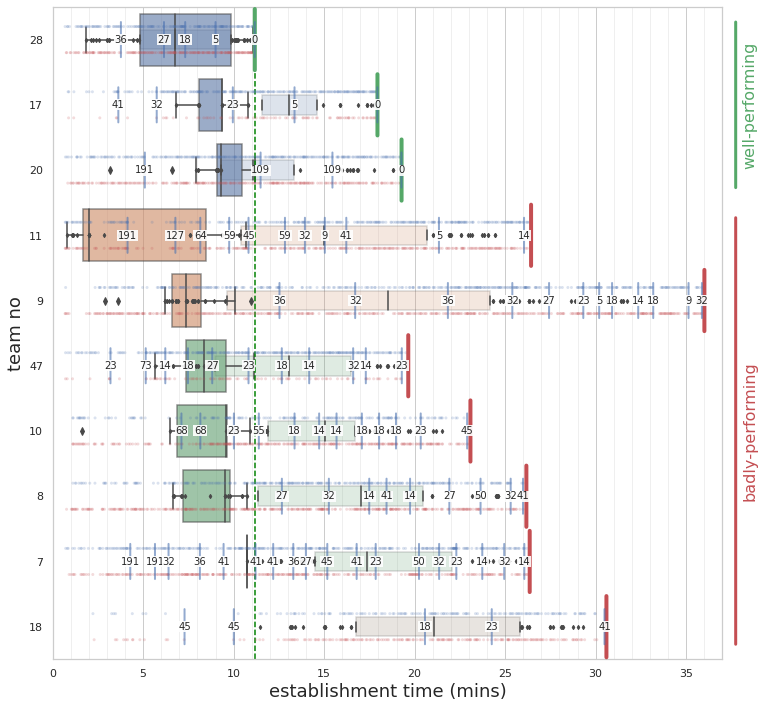

In [38]:
def plot_establishment_absolute(df, x,
                                order,
                                seps=[],
                                y='team_no',
                                save=True,
                                save_filename=None,
                                xlabel=None,
                                show_ylabel=True,
                                show_yticks=True,
                                show_perf_groups=True,
                                fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    my_pal = {'28': colors[0],
              '17': colors[0],
              '20': colors[0],
              '11': colors[1],
              '9': colors[1],
              '47': colors[2],
              '10': colors[2],
              '8': colors[2],
              '7': colors[2],
              '18': colors[5]}
    bp = sns.boxplot(x=x, y=y,
                     order=order,
                     palette=my_pal,
                     boxprops=dict(alpha=.2),
                     width=0.3,
                     showfliers=True,  # False,
                     fliersize=3,
                     whis=0,
                     data=df, ax=ax)

    dff = df[df.in_common_time].copy()
    bp = sns.boxplot(x=x, y=y,
                     order=order,
                     palette=my_pal,
                     boxprops=dict(alpha=.6),
                     #                      whis=0,
                     #                      width=0.1,
                     data=dff, ax=ax)

    # dff = df.copy()
    # dff = dff[dff.is_match | dff.is_mismatch].copy()
    # bp = sns.boxplot(x=x, y=y,
    #                  order=order,
    #                  hue='is_match',
    #                  palette={True: colors[2], False: colors[3]},
    #                  boxprops=dict(alpha=.2),
    #                  # width=0.25,
    #                  data=dff, ax=ax)

    # Set x-axis properties.
    ax.set_xticks(np.arange(0, 2400+1, 300))
#     ax.set_xlim([0, 2400])
    ax.set_xlim([0, 37*60])
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.0f}'.format(x/60)))
    # ax.xaxis.set_major_formatter(
    #     FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=18)

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.grid(True, alpha=0.3, which='minor')

    # Set y-axis properties.
    if show_ylabel:
        ax.set_ylabel('team no', fontsize=18)
    else:
        ax.set_ylabel('')
    if not show_yticks:
        ax.set_yticks([], [])

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    # Annotate by task performance.
    if show_perf_groups:
        l = [0] + seps + [1]
        x = 1.02
        offset = 0.02
        labels = [('well-performing', 'g'),
                  ('badly-performing', 'r')]
        for i, (previous, current) in enumerate(zip(l, l[1:])):
            if isinstance(previous, str):
                previous = (order.index(previous) + 1) / len(order)
            if isinstance(current, str):
                current = (order.index(current) + 1) / len(order)
            previous += offset
            current -= offset
            previous, current = 1 - previous, 1 - current
            s, c = labels[i]
            ax.annotate(s='',
                        xy=(x, previous),
                        xytext=(x, current),
                        xycoords='axes fraction',
                        arrowprops=dict(arrowstyle='-', linewidth=3, color=c))
            t = ax.annotate(s,
                            xy=(x+0.01, (previous+current)/2),
                            fontsize=16,
                            color=c,
                            rotation=90,
                            xycoords='axes fraction',
                            ha='left', va='center')
            
            # # s = 'decreasing \n performance  \n (increasing error)'
            # s = '(decreasing performance)'
            # x = 1.02
            # style = '<-,head_length=0.8,head_width=0.5'
            # props = dict(arrowstyle=style, linewidth=3, color='r')
            # ax.annotate(s='',
            #             xy=(x, 0.1),
            #             xytext=(x, 0.01),
            #             xycoords='axes fraction',
            #             arrowprops=props)
            # t = ax.annotate(s,
            #                 xy=(x+0.01, 0.06),
            #                 fontsize=12,
            #                 rotation=90,
            #                 xycoords='axes fraction',
            #                 ha='left', va='bottom')

    # Mark the common duration with a vertical line.
    ax.axvline(common_duration, ls='--', color='green')

    if fig is not None and save:
        if save_filename is None:
            save_filename = 'h1_1_{}_absolute_plot.png'.format(
                xlabel.split()[-2])
        export_file = plots_dir.joinpath(
            pl.Path(save_filename).with_suffix('.png'))
        # fig.savefig(export_file, bbox_inches='tight')
        # print(export_file)

        export_file = export_file.with_suffix('.pdf')
        fig.savefig(export_file, bbox_inches='tight')
        print(export_file)

    return fig, ax


order, seps = perf_order, perf_seps

figsize = (12, 12)
fig, ax = plt.subplots(figsize=figsize)

# # Plot utterances by marking their end times.
palette = sns.color_palette()
colors = list(palette)
cs = [colors[0], colors[3]]
df = all_corpus_df.copy()
# Filter for the utterances.
df = df[df.utterance_no != -1]
df = df[df.subject.isin(['A', 'B'])]
sns.stripplot(x='end', y='team_no', hue='subject',
              order=order, jitter=0,
              data=df, ax=ax, palette=cs, size=3,
              dodge=True, alpha=0.2)

# Annotate the end of interaction times on the plot.
for team_no, row in counts_df.iterrows():
    if perf_df.T.loc[int(team_no), 'error (%)'] == 0:
        c = 'g'
    else:
        c = 'r'
    pos = row['duration (secs)']
    y = order.index(str(team_no))
    props = dict(arrowstyle='-', alpha=1.0, linewidth=4, color=c)
    ax.annotate(s='',
                xy=(pos, y+0.5),
                xytext=(pos, y-0.5),
                xycoords='data',
                color='green', arrowprops=props)

# Annotate the submission costs on the plot.
for team_no, _ in routine_dfs.items():
    df = all_corpus_df.copy()
    df = df[df.team_no == str(team_no)]
    df = df[df.subject == 'T']
    y = order.index(str(team_no))

    for i, row in df.iterrows():
        arrow_start, arrow_end = 0, 0
        # text_pos = row['scaled_end']
        text_pos = row['end']

        val = row['error']
        s = '{:2.0%}'.format(val).strip('%')
        offset = 0
        props = dict(arrowstyle='-', alpha=0.6, linewidth=2, color='b')
        ax.annotate(s='',
                    xy=(text_pos, y+0.3),
                    xytext=(text_pos, y-0.3),
                    xycoords='data',
                    color='green', arrowprops=props)
        t = ax.annotate(s,
                        xy=(text_pos, y+offset),
                        backgroundcolor='w',
                        fontsize=10,
                        xycoords='data',
                        ha='center', va='center')
        t.set_bbox(dict(fc='w', alpha=0.9, ec='none',
                        boxstyle='square,pad=0.05'))


# Plot the establishment box plots.
x, xlabel = 'establish_time', 'establishment time (mins)'
fig, ax = plot_establishment_absolute(
    all_routines_df, x=x, xlabel=xlabel,
    seps=seps, order=order,
    fig=fig, ax=ax)

#### in normalised time

In [39]:
def plot_establishment(df, x,
                       order,
                       seps=[],
                       y='team_no',
                       save=True,
                       save_filename=None,
                       xlabel=None,
                       show_ylabel=True,
                       show_yticks=True,
                       show_perf_groups=True,
                       fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    my_pal = {'28': colors[0],
              '17': colors[0],
              '20': colors[0],
              '11': colors[1],
              '9': colors[1],
              '47': colors[2],
              '10': colors[2],
              '8': colors[2],
              '7': colors[2],
              '18': colors[5]}
    bp = sns.boxplot(x=x, y=y,
                     order=order,
                     palette=my_pal,
                     boxprops=dict(alpha=.2),
                     data=df, ax=ax)

    # Set x-axis properties.
    ax.set_xticks(np.arange(0, 1.001, 0.1))
    ax.set_xlim([0, 1])
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=18)

    # Set y-axis properties.
    if show_ylabel:
        ax.set_ylabel('team no', fontsize=18)
    else:
        ax.set_ylabel('')
    if not show_yticks:
        ax.set_yticks([], [])

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    # Annotate by task performance.
    if show_perf_groups:
        l = [0] + seps + [1]
        x = 1.02
        offset = 0.02
        labels = [('success', 'g'), ('fail', 'r')]
        for i, (previous, current) in enumerate(zip(l, l[1:])):
            if isinstance(previous, str):
                previous = (order.index(previous) + 1)  /len(order)
            if isinstance(current, str):
                current = (order.index(current) + 1) / len(order)
            previous += offset
            current -= offset
            previous, current = 1 - previous, 1 - current
            s, c = labels[i]
            ax.annotate(s='',
                        xy=(x, previous),
                        xytext=(x, current),
                        xycoords='axes fraction',
                        arrowprops=dict(arrowstyle='-', linewidth=3, color=c))
            t = ax.annotate(s,
                            xy=(x+0.01, (previous+current)/2),
                            fontsize=16,
                            color=c,
                            rotation=90,
                            xycoords='axes fraction',
                            ha='left', va='center')
        s = 'decreasing \n performance  \n (increasing error)'
        s = '(decreasing performance)'
        x = 1.02
        style = '<-,head_length=0.8,head_width=0.5'
        props = dict(arrowstyle=style, linewidth=3, color='r')
        ax.annotate(s='',
                    xy=(x, 0.5),
                    xytext=(x, 0.01),
                    xycoords='axes fraction',
                    arrowprops=props)
        t = ax.annotate(s,
                        xy=(x+0.01, 0.06),
                        fontsize=12,
                        rotation=90,
                        xycoords='axes fraction',
                        ha='left', va='bottom')

    if fig is not None and save:
        if save_filename is None:
            save_filename = 'h1_1_{}_plot.png'.format(xlabel.split()[-2])
        export_file = plots_dir.joinpath(
            pl.Path(save_filename).with_suffix('.png'))
        # fig.savefig(export_file, bbox_inches='tight')
        # print(export_file)

        export_file = export_file.with_suffix('.pdf')
        fig.savefig(export_file, bbox_inches='tight')
        print(export_file)

    return fig, ax

../figures/h1_1_time_plot.pdf


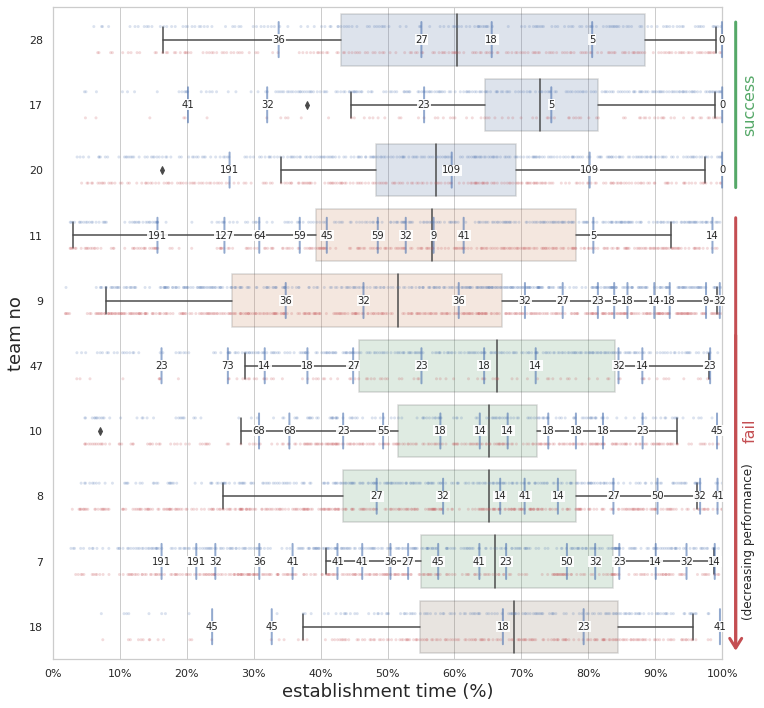

In [40]:
order, seps = perf_order, perf_seps

figsize = (12, 12)
fig, ax = plt.subplots(figsize=figsize)

# Plot utterances by marking their end times.
palette = sns.color_palette()
colors = list(palette)
cs = [colors[0], colors[3]]
df = all_corpus_df.copy()
# Filter for the utterances.
df = df[df.utterance_no != -1]
df = df[df.subject.isin(['A', 'B'])]
sns.stripplot(x='scaled_end', y='team_no', hue='subject',
              order=order, jitter=0,
              data=df, ax=ax, palette=cs, size=3,
              dodge=True, alpha=0.2)

# Annotate the submission costs on the plot.
for team_no, _ in routine_dfs.items():
    df = all_corpus_df.copy()
    df = df[df.team_no == str(team_no)]
    df = df[df.subject == 'T']
    y = order.index(str(team_no))

    for i, row in df.iterrows():
        arrow_start, arrow_end = 0, 0
        text_pos = row['scaled_end']

        val = row['error']
        s = '{:2.0%}'.format(val).strip('%')
        offset = 0
        props = dict(arrowstyle='-', alpha=0.6, linewidth=2, color='b')
        ax.annotate(s='',
                    xy=(text_pos, y+0.3),
                    xytext=(text_pos, y-0.3),
                    xycoords='data',
                    color='green', arrowprops=props)
        t = ax.annotate(s,
                        xy=(text_pos, y+offset),
                        backgroundcolor='w',
                        fontsize=10,
                        xycoords='data',
                        ha='center', va='center')
        t.set_bbox(dict(fc='w', alpha=0.9, ec='none',
                        boxstyle='square,pad=0.05'))
        
# Plot the establishment box plots.
x, xlabel = 'scaled_establish_time', 'establishment time (%)'
fig, ax = plot_establishment(
    all_routines_df, x=x, xlabel=xlabel,
    seps=seps, order=order,
    fig=fig, ax=ax)

## H1.2: When (a) task specific referents become routine and (b) their routines are primed, they are more likely to be surrounded by hesitation phenomena for more successful teams.

### Report filler counts.

In [41]:
fillers = ['um', 'uh', 'hmm', 'ahh', 'oops', 'eww'] # 'mm-hmm', 'uh-uh'
fillers

['um', 'uh', 'hmm', 'ahh', 'oops', 'eww']

In [42]:
tokens_dfs[7].head()

,team_no,utterance_no,token_no,start,end,interlocutor,utterance,token
0,7,0,0,42.525,43.004,A,okay .,okay
1,7,0,1,42.525,43.004,A,okay .,.
2,7,1,2,47.732,48.615,A,i am doing this .,i
3,7,1,3,47.732,48.615,A,i am doing this .,am
4,7,1,4,47.732,48.615,A,i am doing this .,doing


In [43]:
for team_no, df in corpus_dfs.items():
    # # Count the number of fillers for each utterance in the corpus.
    # df['n_fillers'] = df.object.apply(
    #     lambda x: len([t for t in x.split() if t in fillers]))
    # Count the number of info markers i.e. oh's for each utterance in the corpus.
    df['n_info_markers'] = df.object.apply(
        lambda x: len([t for t in x.split() if t == 'oh']))

# Alternatively, mark each token that is a filler in the tokens tables.
for team_no, df in tokens_dfs.items():
    df['is_filler'] = df.token.apply(lambda x: x.strip() in fillers)

In [44]:
for filler in fillers:
    counts = list()
    for team_no, df in tokens_dfs.items():
        count = df.token.apply(lambda x: x.strip() == filler).sum()
        counts.append(count)

    print(filler, np.sum(counts), np.mean(counts), '{:.2f}'.format(np.std(counts)))

um 236 23.6 13.51
uh 173 17.3 9.69
hmm 3 0.3 0.90
ahh 4 0.4 0.66
oops 4 0.4 0.66
eww 1 0.1 0.30


### Perform Mann-Whitney U test and compute Cliff's Delta

#### for establishment

In [45]:
def test_fillers_and_routines(filler_col, routine_col,
                              n1='filler',
                              n2='establishment',
                              verbose=True):
    n1_col = 'N_{}'.format(n1)
    n2_col = 'N_{}'.format(n2)
    m1_col = 'median (%)_{}'.format(n1)
    m2_col = 'median (%)_{}'.format(n2)
    u_col = '{}_U'.format(n2)
    p_col = '{}_p'.format(n2)
    d_col = '{}_d'.format(n2)
    data = {
        'Team': [],
        n1_col: [], n2_col: [],
        m1_col: [], m2_col: [],
        u_col: [],
        p_col: [],
        d_col: [],
    }

    order = [int(t) for t in perf_order]

    for team_no in order:
        routine_df = routine_dfs[team_no]

        # # filter for the fillers of this team.
        df = tokens_dfs[team_no]
        filler_df = df[df.is_filler]

        x = filler_df[filler_col].values
        y = routine_df[routine_col].values

        u, pvalue = scipy.stats.mannwhitneyu(x=x, y=y, 
                                             use_continuity=False,
                                             alternative='two-sided')
        thres = 0.05
        if pvalue < thres:
            ps = 'p < ' + '{:.2f}'.format(thres).lstrip('0')
        else:
            ps = 'p = ' + '{:.2f}'.format(pvalue).lstrip('0')

        d, size = cliffsDelta.cliffsDelta(x, y)
        if verbose:
            print('For Team {:02d}: '.format(team_no), end='')
            s = '$U = {:6.1f}$, ${}$'.format(u, ps)
            s += r", $\text{Cliff's delta}"
            s += " = {:.2f}$".format(d).lstrip('0')
            s += r' \\'
            print(s)

        data['Team'].append(team_no)
        data[n1_col].append(len(x))
        data[n2_col].append(len(y))
        data[m1_col].append('{:.1f}'.format(np.median(x)/60))
        data[m2_col].append('{:.1f}'.format(np.median(y)/60))
        data[u_col].append(u)
        data[p_col].append('< .05' if pvalue <
                           0.05 else '{:.2f}'.format(pvalue).lstrip('0'))
        data[d_col].append('{:.2f}'.format(d))

    data_df = pd.DataFrame.from_dict(data)
    data_df.set_index('Team', inplace=True)

    data_df[p_col] = [r'${}$'.format(p) for p in data_df[p_col]]

    idx = data_df.columns.str.split('_', expand=True)
    idx = list(idx)
    for i, (level0, level1) in enumerate(idx):
        if type(level1) is not str and math.isnan(level1):
            idx[i] = (level0, '.')
    idx = pd.MultiIndex.from_tuples(idx)
    data_df.columns = idx

    data_df = data_df.loc[order]
    return data_df


print("U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different")
print("Cliff's delta \> 0 indicates filler times (or equivalently utterance positions) larger than establishment times. \< otherwise.")
print('filler positions vs.\ establishment positions (sorted by increasing learning):')

routine_col, filler_col = 'establish_token', 'token_no'
establish_df = test_fillers_and_routines(
    filler_col, routine_col, n2='establishment')

display(establish_df)
print(establish_df.to_latex(escape=False))

U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different
Cliff's delta \> 0 indicates filler times (or equivalently utterance positions) larger than establishment times. \< otherwise.
filler positions vs.\ establishment positions (sorted by increasing learning):
For Team 28: $U =  828.5$, $p < .05$, $\text{Cliff's delta} = -0.25$ \\
For Team 17: $U =  431.0$, $p = .12$, $\text{Cliff's delta} = -0.22$ \\
For Team 20: $U = 1139.5$, $p < .05$, $\text{Cliff's delta} = -0.24$ \\
For Team 11: $U = 1624.0$, $p < .05$, $\text{Cliff's delta} = 0.33$ \\
For Team 09: $U = 6561.5$, $p < .05$, $\text{Cliff's delta} = 0.24$ \\
For Team 47: $U = 1627.0$, $p < .05$, $\text{Cliff's delta} = -0.21$ \\
For Team 10: $U =  660.0$, $p = .92$, $\text{Cliff's delta} = 0.02$ \\
For Team 08: $U =  461.0$, $p < .05$, $\text{Cliff's delta} = -0.43$ \\
For Team 07: $U =  259.0$, $p < .05$, $\text{Cliff's delta} = -0.67$ \\
For Team 18: $U = 1326.0$

N               median (%)               establishment           \
     filler establishment     filler establishment             U        p   
Team                                                                        
28       38            58       11.6          15.2         828.5  $< .05$   
17       27            41       14.0          17.1         431.0    $.12$   
20       59            51       20.7          22.8        1139.5  $< .05$   
11       35            70       34.5          24.4        1624.0  $< .05$   
9        81           131       46.3          37.4        6561.5  $< .05$   
47       56            74       19.5          21.9        1627.0  $< .05$   
10       20            65       20.1          20.4         660.0    $.92$   
8        26            62       19.8          36.0         461.0  $< .05$   
7        27            59       24.9          37.8         259.0  $< .05$   
18       52            57       10.8          11.8        1326.0    $.34$   

             
          d  
Team         
28    -0.25  
17    -0.22  
20    -0.24  
11     0.33  
9      0.24  
47    -0.21  
10     0.02  
8     -0.43  
7     -0.67  
18    -0.11

\begin{tabular}{lrrllrll}
\toprule
{} & \multicolumn{2}{l}{N} & \multicolumn{2}{l}{median (%)} & \multicolumn{3}{l}{establishment} \\
{} & filler & establishment &     filler & establishment &             U &        p &      d \\
Team &        &               &            &               &               &          &        \\
\midrule
28   &     38 &            58 &       11.6 &          15.2 &         828.5 &  $< .05$ &  -0.25 \\
17   &     27 &            41 &       14.0 &          17.1 &         431.0 &    $.12$ &  -0.22 \\
20   &     59 &            51 &       20.7 &          22.8 &        1139.5 &  $< .05$ &  -0.24 \\
11   &     35 &            70 &       34.5 &          24.4 &        1624.0 &  $< .05$ &   0.33 \\
9    &     81 &           131 &       46.3 &          37.4 &        6561.5 &  $< .05$ &   0.24 \\
47   &     56 &            74 &       19.5 &          21.9 &        1627.0 &  $< .05$ &  -0.21 \\
10   &     20 &            65 &       20.1 &          20.4 &         660.0 

#### for priming

In [46]:
routine_col, filler_col = 'priming_token', 'token_no'
priming_df = test_fillers_and_routines(filler_col, routine_col, n2='priming')

display(priming_df)
print(priming_df.to_latex(escape=False))

For Team 28: $U = 1600.5$, $p < .05$, $\text{Cliff's delta} = 0.45$ \\
For Team 17: $U =  823.0$, $p < .05$, $\text{Cliff's delta} = 0.49$ \\
For Team 20: $U = 1746.5$, $p = .15$, $\text{Cliff's delta} = 0.16$ \\
For Team 11: $U = 2229.0$, $p < .05$, $\text{Cliff's delta} = 0.82$ \\
For Team 09: $U = 8805.5$, $p < .05$, $\text{Cliff's delta} = 0.66$ \\
For Team 47: $U = 3189.0$, $p < .05$, $\text{Cliff's delta} = 0.54$ \\
For Team 10: $U =  982.0$, $p < .05$, $\text{Cliff's delta} = 0.51$ \\
For Team 08: $U =  883.0$, $p = .48$, $\text{Cliff's delta} = 0.10$ \\
For Team 07: $U =  562.0$, $p < .05$, $\text{Cliff's delta} = -0.29$ \\
For Team 18: $U = 2136.0$, $p < .05$, $\text{Cliff's delta} = 0.44$ \\


N         median (%)         priming                
     filler priming     filler priming       U        p      d
Team                                                          
28       38      58       11.6     3.5  1600.5  $< .05$   0.45
17       27      41       14.0     6.2   823.0  $< .05$   0.49
20       59      51       20.7    18.1  1746.5    $.15$   0.16
11       35      70       34.5     3.5  2229.0  $< .05$   0.82
9        81     131       46.3    11.4  8805.5  $< .05$   0.66
47       56      74       19.5     6.7  3189.0  $< .05$   0.54
10       20      65       20.1     8.7   982.0  $< .05$   0.51
8        26      62       19.8    15.7   883.0    $.48$   0.10
7        27      59       24.9    25.9   562.0  $< .05$  -0.29
18       52      57       10.8     4.3  2136.0  $< .05$   0.44

\begin{tabular}{lrrllrll}
\toprule
{} & \multicolumn{2}{l}{N} & \multicolumn{2}{l}{median (%)} & \multicolumn{3}{l}{priming} \\
{} & filler & priming &     filler & priming &       U &        p &      d \\
Team &        &         &            &         &         &          &        \\
\midrule
28   &     38 &      58 &       11.6 &     3.5 &  1600.5 &  $< .05$ &   0.45 \\
17   &     27 &      41 &       14.0 &     6.2 &   823.0 &  $< .05$ &   0.49 \\
20   &     59 &      51 &       20.7 &    18.1 &  1746.5 &    $.15$ &   0.16 \\
11   &     35 &      70 &       34.5 &     3.5 &  2229.0 &  $< .05$ &   0.82 \\
9    &     81 &     131 &       46.3 &    11.4 &  8805.5 &  $< .05$ &   0.66 \\
47   &     56 &      74 &       19.5 &     6.7 &  3189.0 &  $< .05$ &   0.54 \\
10   &     20 &      65 &       20.1 &     8.7 &   982.0 &  $< .05$ &   0.51 \\
8    &     26 &      62 &       19.8 &    15.7 &   883.0 &    $.48$ &   0.10 \\
7    &     27 &      59 &       24.9 &    25.9 &   562.0 &  $< .0

#### merge establishment and priming results into a single table

In [47]:
col_list = [('N', 'filler'),
            ('N', 'priming'),
#             ('N','establishment'),
            ('median (%)', 'filler'),
            ('median (%)', 'priming'),
            ('median (%)', 'establishment'),
            ('priming', 'U'),
            ('priming', 'p'),
            ('priming', 'd'),
            ('establishment', 'U'),
            ('establishment', 'p'),
            ('establishment', 'd'),
           ]
           
columns = pd.Index(col_list)

df = pd.concat([establish_df, priming_df], axis=1)
df = df.loc[:, columns]
df = df.loc[:, ~df.columns.duplicated()]

display(df)
print(df.to_latex(escape=False))

N         median (%)                       priming                  \
     filler priming     filler priming establishment       U        p      d   
Team                                                                           
28       38      58       11.6     3.5          15.2  1600.5  $< .05$   0.45   
17       27      41       14.0     6.2          17.1   823.0  $< .05$   0.49   
20       59      51       20.7    18.1          22.8  1746.5    $.15$   0.16   
11       35      70       34.5     3.5          24.4  2229.0  $< .05$   0.82   
9        81     131       46.3    11.4          37.4  8805.5  $< .05$   0.66   
47       56      74       19.5     6.7          21.9  3189.0  $< .05$   0.54   
10       20      65       20.1     8.7          20.4   982.0  $< .05$   0.51   
8        26      62       19.8    15.7          36.0   883.0    $.48$   0.10   
7        27      59       24.9    25.9          37.8   562.0  $< .05$  -0.29   
18       52      57       10.8     4.3          11.8  2136.0  $< .05$   0.44   

     establishment                  
                 U        p      d  
Team                                
28           828.5  $< .05$  -0.25  
17           431.0    $.12$  -0.22  
20          1139.5  $< .05$  -0.24  
11          1624.0  $< .05$   0.33  
9           6561.5  $< .05$   0.24  
47          1627.0  $< .05$  -0.21  
10           660.0    $.92$   0.02  
8            461.0  $< .05$  -0.43  
7            259.0  $< .05$  -0.67  
18          1326.0    $.34$  -0.11

\begin{tabular}{lrrlllrllrll}
\toprule
{} & \multicolumn{2}{l}{N} & \multicolumn{3}{l}{median (%)} & \multicolumn{3}{l}{priming} & \multicolumn{3}{l}{establishment} \\
{} & filler & priming &     filler & priming & establishment &       U &        p &      d &             U &        p &      d \\
Team &        &         &            &         &               &         &          &        &               &          &        \\
\midrule
28   &     38 &      58 &       11.6 &     3.5 &          15.2 &  1600.5 &  $< .05$ &   0.45 &         828.5 &  $< .05$ &  -0.25 \\
17   &     27 &      41 &       14.0 &     6.2 &          17.1 &   823.0 &  $< .05$ &   0.49 &         431.0 &    $.12$ &  -0.22 \\
20   &     59 &      51 &       20.7 &    18.1 &          22.8 &  1746.5 &    $.15$ &   0.16 &        1139.5 &  $< .05$ &  -0.24 \\
11   &     35 &      70 &       34.5 &     3.5 &          24.4 &  2229.0 &  $< .05$ &   0.82 &        1624.0 &  $< .05$ &   0.33 \\
9    &     81 &     131 &       4

# RQ2: How do the interlocutors follow up the use of task specific referents with actions? Does this link to task success?

## H2.1: Instructions are more likely to be followed by the corresponding actions earlier in the dialogue for more successful teams.

### Compute mean of medians and SD (and mean).

#### for matches

In [48]:
df = all_corpus_df.copy()
df = df[df.match.notnull()]
of = 'scaled_end'
compute_combined_mean_median_sd(df, of=of)

combined mean = 62.76% , combined SD = 21.7%
mean of the medians = 62.1%


#### for mismatches

In [49]:
df = all_corpus_df.copy()
df = df[df.mismatch.notnull()]
of = 'scaled_end'
compute_combined_mean_median_sd(df, of=of)

combined mean = 63.00% , combined SD = 25.3%
mean of the medians = 67.4%


### Plot (mis)match time distributions.

In [50]:
# # Plot match and mismatch times.
# df = all_corpus_df
# dff = df.copy()
# dff = dff[dff.is_match | dff.is_mismatch].copy()
# x = 'scaled_end'
# bp = sns.boxplot(x=x, y='team_no',
# #                  order=order,
#                  hue='is_match',
# #                  palette={True: colors[2], False: colors[3]},
# #                  boxprops=dict(alpha=.2),
# #                  # width=0.25,
#                  data=dff) #, ax=ax)
# # dff

In [51]:
def plot_matches(df, x,
                 order,
                 seps=[],
                 y='team_no',
                 save=True,
                 save_filename=None,
                 xlabel=None,
                 show_ylabel=True,
                 show_yticks=True,
                 show_perf_groups=False,
                 show_learn_groups=False,
                 fig=None, ax=None):
    '''Creates box plots of matches and mismatches in a figure'''
    # Create a new figure if not supplied.
    if fig is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    # # Plot establishment times.
    # bp = sns.boxplot(x='scaled_establish_time', y=y,
    #              order=order,
    #              width=0.4,
    #              boxprops=dict(alpha=.6),
    #              data=all_routines_df, ax=ax)

    # # Plot instruction times.
    # dff = df.copy()
    offset1, offset2 = 0.2, -0.1
    # dff = dff[dff['n_instructions'] > 0]
    # for team_no in order:
    #     index = order.index(str(team_no))
    #     xs = dff[dff.team_no == str(team_no)][x]
    #     ys = index + offset1 + 2 * offset2
    #     sns.scatterplot(x=xs, y=ys,
    #                     color=colors[1],
    #                     marker='^', linewidth=0,
    #                     ax=ax)
    # bp = sns.boxplot(x=x, y=y,
    #                  order=order,
    #                  boxprops=dict(alpha=.2),
    #                  data=dff, ax=ax)

    # Plot match and mismatch times.
    dff = df.copy()
    dff = dff[dff.is_match | dff.is_mismatch].copy()
    bp = sns.boxplot(x=x, y=y,
                     order=order,
                     hue='is_match',
                     palette={True: colors[2], False: colors[3]},
                     boxprops=dict(alpha=.2),
                     # width=0.25,
                     data=dff, ax=ax)

    # Plot match times, with a "plus".
    dff = df.copy()
    dff = dff[dff['is_match']]
    for team_no in order:
        index = order.index(str(team_no))
        xs = dff[dff.team_no == str(team_no)][x]
        ys = index + offset1
        sns.scatterplot(x=xs, y=ys,
                        color=colors[2],
                        marker='P', linewidth=0,
                        ax=ax)

    # Plot mismatch times, with a "cross".
    dff = df.copy()
    dff = dff[dff['is_mismatch']]
    for team_no in order:
        index = order.index(str(team_no))
        xs = dff[dff.team_no == str(team_no)][x]
        ys = index - offset1
        sns.scatterplot(x=xs, y=ys,
                        color=colors[3],
                        marker='X', linewidth=0,
                        ax=ax)

    # Set x-axis properties.
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=18)

    # Set y-axis properties.
    if show_ylabel:
        ax.set_ylabel('team no', fontsize=18)
    else:
        ax.set_ylabel('')
    if not show_yticks:
        ax.set_yticks([], [])

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    # Annotate the groups of task performance (success or fail).
    if show_perf_groups:
        l = [0] + seps + [1]
        x, offset = 1.02, 0.02
        labels = [('success', 'g'), ('fail', 'r')]
        for i, (previous, current) in enumerate(zip(l, l[1:])):
            if isinstance(previous, str):
                previous = (order.index(previous) + 1) / len(order)
            if isinstance(current, str):
                current = (order.index(current) + 1) / len(order)
            previous += offset
            current -= offset
            previous, current = 1 - previous, 1 - current
            s, c = labels[i]
            ax.annotate(s='',
                        xy=(x, previous),
                        xytext=(x, current),
                        xycoords='axes fraction',
                        arrowprops=dict(arrowstyle='-', linewidth=3, color=c))
            t = ax.annotate(s,
                            xy=(x+0.01, (previous+current)/2),
                            fontsize=16,
                            color=c,
                            rotation=90,
                            xycoords='axes fraction',
                            ha='left', va='center')

        s = '(decreasing performance)'  # + '\n (increasing error)''
        x = 1.02
        style = '<-,head_length=0.8,head_width=0.5'
        props = dict(arrowstyle=style, linewidth=3, color='r')
        ax.annotate(s='',
                    xy=(x, 0.5),
                    xytext=(x, 0.01),
                    xycoords='axes fraction',
                    arrowprops=props)
        t = ax.annotate(s,
                        xy=(x+0.01, 0.06),
                        fontsize=12,
                        rotation=90,
                        xycoords='axes fraction',
                        ha='left', va='bottom')

    # Annotate the groups of learning outcomes.
    if show_learn_groups:
        l = [0] + seps + [1]
        x, offset = 1.02, 0.02
        labels = ['learn > 0', 'learn = 0', 'learn < 0']
        for i, (previous, current) in enumerate(zip(l, l[1:])):
            if isinstance(previous, str):
                previous = (order.index(previous)+1) / len(order)
            if isinstance(current, str):
                current = (order.index(current)+1) / len(order)
            previous += offset
            current -= offset
            previous, current = 1 - previous, 1 - current
            style = '-'
            if i == 0:
                # show the increasing direction
                style = '->,head_length=0.8,head_width=0.5'
            ax.annotate(s='',
                        xy=(x, previous),
                        xytext=(x, current),
                        xycoords='axes fraction',
                        arrowprops=dict(arrowstyle=style, linewidth=3, color='g'))
            s = labels[i]
            t = ax.annotate(s,
                            xy=(x+0.01, (previous+current)/2),
                            fontsize=16,
                            rotation=90,
                            xycoords='axes fraction',
                            ha='left', va='center')

    if fig is not None and save:
        if save_filename is None:
            save_filename = 'h2_1_{}_plot'.format(xlabel.split()[-2])
            if show_perf_groups:
                save_filename += '_by-perf'
            elif show_learn_groups:
                save_filename += '_by-learn'
            save_filename += '.png'

        export_file = plots_dir.joinpath(
            pl.Path(save_filename).with_suffix('.png'))

        # # Export as png - bitmap.
        # fig.savefig(export_file, bbox_inches='tight')
        # print(export_file)

        # Export as pdf - vector graphics.
        export_file = export_file.with_suffix('.pdf')
        fig.savefig(export_file, bbox_inches='tight')
        print(export_file)

    return fig, ax

../figures/h2_1_time_plot_by-learn.pdf


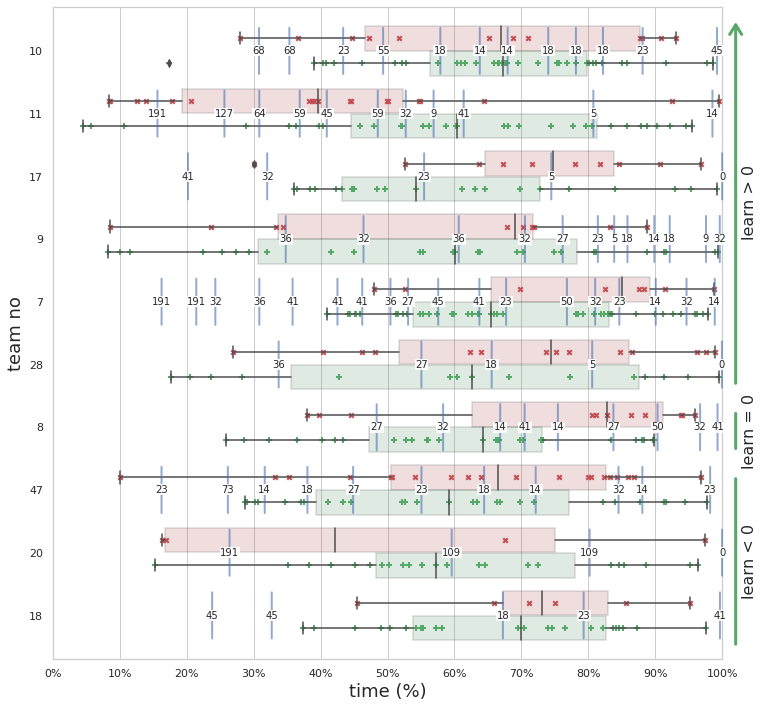

In [52]:
# Order teams by performance.
# order, seps = perf_order, perf_seps
order, seps = learn_order, learn_seps

figsize = (12, 12)
fig, ax = plt.subplots(figsize=figsize)

palette = sns.color_palette()
colors = list(palette)
cs = [colors[0], colors[3]]
df = all_corpus_df.copy()

# Annotate the submission costs on the plot.
for team_no, _ in routine_dfs.items():
    df = all_corpus_df.copy()
    df = df[df.team_no == str(team_no)]
    df = df[df.subject == 'T']
    y = order.index(str(team_no))

    for i, row in df.iterrows():
        arrow_start, arrow_end = 0, 0
        text_pos = row['scaled_end']

        val = row['error']
        s = '{:2.0%}'.format(val).strip('%')
        offset = 0.4
        props = dict(arrowstyle='-', alpha=0.6, linewidth=2, color='b')
        ax.annotate(s='',
                    xy=(text_pos, y+offset),
                    xytext=(text_pos, y-offset),
                    xycoords='data',
                    color='green', arrowprops=props)
        offset = 0
        t = ax.annotate(s,
                        xy=(text_pos, y+offset),
                        backgroundcolor='w',
                        fontsize=10,
                        xycoords='data',
                        ha='center', va='center')
        t.set_bbox(dict(fc='w', alpha=0.9, ec='none',
                        boxstyle='square,pad=0.05'))
    

# Create box plots of matches and mismatches.
x, xlabel = 'scaled_end', 'time (%)'
fig, ax = plot_matches(
    all_corpus_df, x=x, xlabel=xlabel,
    seps=seps, order=order,
    fig=fig, ax=ax, 
#     show_perf_groups=True)
    show_learn_groups=True)

ax.set_xticks(np.arange(0, 1.001, 0.1))
ax.set_xlim([0, 1])
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

../figures/h2_1_time_plot_by-learn.pdf


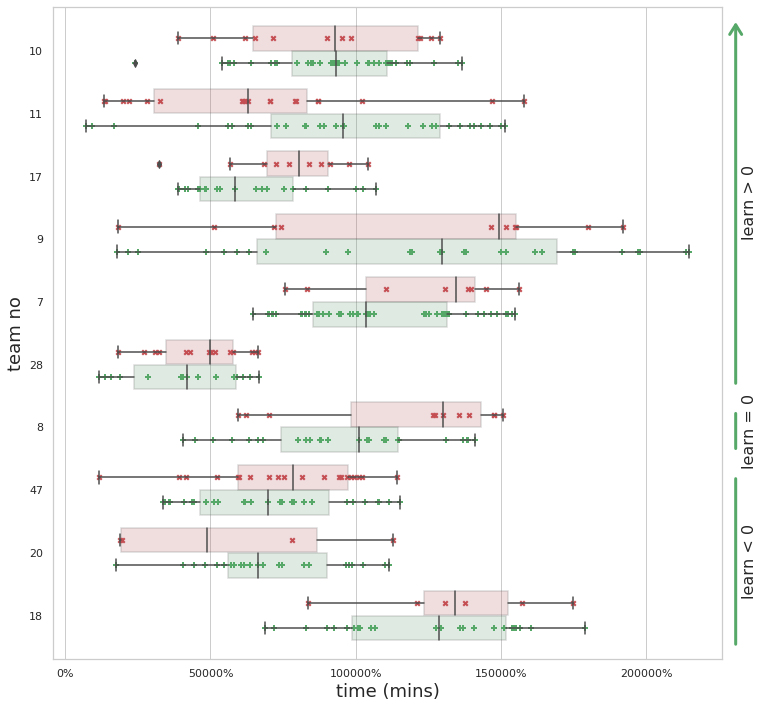

In [53]:
figsize = (12, 12)
fig, ax = plt.subplots(figsize=figsize)

# Create box plots of matches and mismatches.
x, xlabel = 'scaled_end', 'time (%)'
x, xlabel = 'end', 'time (mins)'
fig, ax = plot_matches(
    all_corpus_df, x=x, xlabel=xlabel,
    seps=seps, order=order,
    fig=fig, ax=ax, 
#     show_perf_groups=True)
    show_learn_groups=True)

# ax.set_xticks(np.arange(0, 1.001, 0.1))
# ax.set_xlim([0, 1])
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

## H2.2: When instructions are followed by the corresponding actions (or another action), they are more likely to be surrounded by information management phenomena for more successful teams.

### Report oh counts.

In [54]:
for marker in ['oh']:
    counts = list()
    for team_no, df in tokens_dfs.items():
        count = df.token.apply(lambda x: x.strip() == marker).sum()
        counts.append(count)

    print(marker, np.sum(counts), np.mean(counts), '{:.2f}'.format(np.std(counts)))

oh 333 33.3 19.26


### Perform Mann-Whitney U test and compute Cliff's Delta

#### for matches

In [55]:
def test_marker_and_matches(match_col,
                            n1='oh',
                            n2='match',
                            verbose=True):
    n1_col = 'N_{}'.format(n1)
    n2_col = 'N_{}'.format(n2)
    m1_col = 'median (%)_{}'.format(n1)
    m2_col = 'median (%)_{}'.format(n2)
    u_col = '{}_U'.format(n2)
    p_col = '{}_p'.format(n2)
    d_col = '{}_d'.format(n2)
    data = {
        'Team': [],
        n1_col: [], n2_col: [],
        m1_col: [], m2_col: [],
        u_col: [], 
        p_col: [], 
        d_col: [],
    }

    order = [int(t) for t in learn_order]
    # order = [int(t) for t in perf_order]

    for team_no in order:
        routine_df = routine_dfs[team_no]

        # Filter for the markers of this team.
        df = corpus_dfs[team_no].copy()
        df = df[df.subject.isin(['A', 'B'])]
        marker_df = df[df.n_info_markers > 0]
        x = marker_df['scaled_end'].values

        # Filter for the (mis)matches of this team.
        df = corpus_dfs[team_no].copy()
        df = df[df[match_col]]
        y = df['scaled_end'].values

        u, pvalue = scipy.stats.mannwhitneyu(x=x, y=y,
                                             use_continuity=False,
                                             alternative='two-sided')
        thres = 0.05
        if pvalue < thres:
            ps = 'p < ' + '{:.2f}'.format(thres).lstrip('0')
        else:
            ps = 'p = ' + '{:.2f}'.format(pvalue).lstrip('0')

        d, size = cliffsDelta.cliffsDelta(x, y)
        if verbose:
            print('For Team {:02d}: '.format(team_no), end='')
            s = '$U = {:6.1f}$, ${}$'.format(u, ps)
            s += r", $\text{Cliff's delta}"
            s += " = {:.2f}$".format(d).lstrip('0')
            s += r' \\'
            print(s)

        data['Team'].append(team_no)
        data[n1_col].append(len(x))
        data[n2_col].append(len(y))
        data[m1_col].append('{:.1f}'.format(100*np.median(x)))
        data[m2_col].append('{:.1f}'.format(100*np.median(y)))
        data[u_col].append(u)
        data[p_col].append('< .05' if pvalue <
                         0.05 else '{:.2f}'.format(pvalue).lstrip('0'))
        data[d_col].append('{:.2f}'.format(d))

    data_df = pd.DataFrame.from_dict(data)
    data_df.set_index('Team', inplace=True)

    data_df[p_col] = [r'${}$'.format(p) for p in data_df[p_col]]

    idx = data_df.columns.str.split('_', expand=True)
    idx = list(idx)
    for i, (level0, level1) in enumerate(idx):
        if type(level1) is not str and math.isnan(level1):
            idx[i] = (level0, '.')
    idx = pd.MultiIndex.from_tuples(idx)
    data_df.columns = idx

    data_df = data_df.loc[order]
    return data_df


print("U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different")
print("Cliff's delta \> 0 indicates info marker (oh) times larger than match times. \< otherwise.")
print('oh times vs.\ match times (sorted by decreasing task performance (i.e.\ increasing error):')

match_df = test_marker_and_matches('is_match', n2='match')

display(match_df)
# print(match_df.to_latex(escape=False))

U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different
Cliff's delta \> 0 indicates info marker (oh) times larger than match times. \< otherwise.
oh times vs.\ match times (sorted by decreasing task performance (i.e.\ increasing error):
For Team 10: $U =  177.0$, $p < .05$, $\text{Cliff's delta} = -0.45$ \\
For Team 11: $U =  220.0$, $p = .65$, $\text{Cliff's delta} = -0.08$ \\
For Team 17: $U =  218.0$, $p = .83$, $\text{Cliff's delta} = 0.04$ \\
For Team 09: $U =  311.0$, $p = .19$, $\text{Cliff's delta} = -0.21$ \\
For Team 07: $U =  670.0$, $p < .05$, $\text{Cliff's delta} = -0.39$ \\
For Team 28: $U =  168.0$, $p = .73$, $\text{Cliff's delta} = -0.07$ \\
For Team 08: $U =  393.0$, $p < .05$, $\text{Cliff's delta} = -0.47$ \\
For Team 47: $U =  297.0$, $p = .12$, $\text{Cliff's delta} = -0.24$ \\
For Team 20: $U =  510.0$, $p < .05$, $\text{Cliff's delta} = -0.32$ \\
For Team 18: $U =  123.0$, $p = .48$, $\text{Cl

N       median (%)        match                
      oh match         oh match      U        p      d
Team                                                  
10    18    36       47.6  67.3  177.0  $< .05$  -0.45
11    15    32       57.3  60.3  220.0    $.65$  -0.08
17    20    21       61.1  54.3  218.0    $.83$   0.04
9     29    27       42.9  60.1  311.0    $.19$  -0.21
7     51    43       49.7  65.5  670.0  $< .05$  -0.39
28    24    15       61.7  62.7  168.0    $.73$  -0.07
8     55    27       36.3  64.3  393.0  $< .05$  -0.47
47    29    27       53.4  59.1  297.0    $.12$  -0.24
20    65    23       35.0  57.3  510.0  $< .05$  -0.32
18    12    24       69.6  70.0  123.0    $.48$  -0.15

#### for mismatches

In [56]:
print("U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different")
print("Cliff's delta \> 0 indicates info marker (oh) times larger than mismatch times. \< otherwise.")
print('oh times vs.\ mismatch times (sorted by decreasing task performance (i.e.\ increasing error):')

mismatch_df = test_marker_and_matches('is_mismatch', n2='mismatch')

display(mismatch_df)
# print(mismatch_df.to_latex(escape=False))

U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different
Cliff's delta \> 0 indicates info marker (oh) times larger than mismatch times. \< otherwise.
oh times vs.\ mismatch times (sorted by decreasing task performance (i.e.\ increasing error):
For Team 10: $U =   65.0$, $p = .07$, $\text{Cliff's delta} = -0.40$ \\
For Team 11: $U =  174.0$, $p = .27$, $\text{Cliff's delta} = 0.22$ \\
For Team 17: $U =   73.0$, $p = .23$, $\text{Cliff's delta} = -0.27$ \\
For Team 09: $U =  118.0$, $p = .39$, $\text{Cliff's delta} = -0.19$ \\
For Team 07: $U =   89.0$, $p < .05$, $\text{Cliff's delta} = -0.56$ \\
For Team 28: $U =  128.0$, $p = .23$, $\text{Cliff's delta} = -0.24$ \\
For Team 08: $U =  102.0$, $p < .05$, $\text{Cliff's delta} = -0.66$ \\
For Team 47: $U =  182.0$, $p < .05$, $\text{Cliff's delta} = -0.37$ \\
For Team 20: $U =  131.0$, $p = .98$, $\text{Cliff's delta} = 0.01$ \\
For Team 18: $U =   26.0$, $p = .35$, $\te

N          median (%)          mismatch                
      oh mismatch         oh mismatch        U        p      d
Team                                                          
10    18       12       47.6     67.0     65.0    $.07$  -0.40
11    15       19       57.3     39.6    174.0    $.27$   0.22
17    20       10       61.1     74.7     73.0    $.23$  -0.27
9     29       10       42.9     69.0    118.0    $.39$  -0.19
7     51        8       49.7     85.0     89.0  $< .05$  -0.56
28    24       14       61.7     74.4    128.0    $.23$  -0.24
8     55       11       36.3     82.7    102.0  $< .05$  -0.66
47    29       20       53.4     66.6    182.0  $< .05$  -0.37
20    65        4       35.0     42.2    131.0    $.98$   0.01
18    12        6       69.6     73.1     26.0    $.35$  -0.28

#### for match or mismatch.

In [57]:
print("U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different")
print("Cliff's delta \> 0 indicates info marker (oh) times larger than mismatch times. \< otherwise.")
print('oh times vs.\ match or mismatch times (sorted by decreasing task performance (i.e.\ increasing error):')

match_mismatch_df = test_marker_and_matches('is_match_or_mismatch', n2='match/mismatch')

display(match_mismatch_df)
print(match_mismatch_df.to_latex(escape=False))

U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different
Cliff's delta \> 0 indicates info marker (oh) times larger than mismatch times. \< otherwise.
oh times vs.\ match or mismatch times (sorted by decreasing task performance (i.e.\ increasing error):
For Team 10: $U =  242.0$, $p < .05$, $\text{Cliff's delta} = -0.44$ \\
For Team 11: $U =  394.0$, $p = .86$, $\text{Cliff's delta} = 0.03$ \\
For Team 17: $U =  291.0$, $p = .71$, $\text{Cliff's delta} = -0.06$ \\
For Team 09: $U =  429.0$, $p = .16$, $\text{Cliff's delta} = -0.20$ \\
For Team 07: $U =  759.0$, $p < .05$, $\text{Cliff's delta} = -0.42$ \\
For Team 28: $U =  296.0$, $p = .35$, $\text{Cliff's delta} = -0.15$ \\
For Team 08: $U =  495.0$, $p < .05$, $\text{Cliff's delta} = -0.53$ \\
For Team 47: $U =  479.0$, $p < .05$, $\text{Cliff's delta} = -0.30$ \\
For Team 20: $U =  641.0$, $p < .05$, $\text{Cliff's delta} = -0.27$ \\
For Team 18: $U =  149.0$, $p = 

N                median (%)                match/mismatch           \
      oh match/mismatch         oh match/mismatch              U        p   
Team                                                                        
10    18             48       47.6           67.3          242.0  $< .05$   
11    15             51       57.3           52.2          394.0    $.86$   
17    20             31       61.1           63.7          291.0    $.71$   
9     29             37       42.9           63.5          429.0    $.16$   
7     51             51       49.7           66.4          759.0  $< .05$   
28    24             29       61.7           68.2          296.0    $.35$   
8     55             38       36.3           66.5          495.0  $< .05$   
47    29             47       53.4           62.7          479.0  $< .05$   
20    65             27       35.0           57.3          641.0  $< .05$   
18    12             30       69.6           70.8          149.0    $.39$   

             
          d  
Team         
10    -0.44  
11     0.03  
17    -0.06  
9     -0.20  
7     -0.42  
28    -0.15  
8     -0.53  
47    -0.30  
20    -0.27  
18    -0.17

\begin{tabular}{lrrllrll}
\toprule
{} & \multicolumn{2}{l}{N} & \multicolumn{2}{l}{median (%)} & \multicolumn{3}{l}{match/mismatch} \\
{} &  oh & match/mismatch &         oh & match/mismatch &              U &        p &      d \\
Team &     &                &            &                &                &          &        \\
\midrule
10   &  18 &             48 &       47.6 &           67.3 &          242.0 &  $< .05$ &  -0.44 \\
11   &  15 &             51 &       57.3 &           52.2 &          394.0 &    $.86$ &   0.03 \\
17   &  20 &             31 &       61.1 &           63.7 &          291.0 &    $.71$ &  -0.06 \\
9    &  29 &             37 &       42.9 &           63.5 &          429.0 &    $.16$ &  -0.20 \\
7    &  51 &             51 &       49.7 &           66.4 &          759.0 &  $< .05$ &  -0.42 \\
28   &  24 &             29 &       61.7 &           68.2 &          296.0 &    $.35$ &  -0.15 \\
8    &  55 &             38 &       36.3 &           66.5 &          495.0

#### merge match and mismatch results into a single table

In [58]:
col_list = [('N', 'oh'),
            ('N', 'match'),
            ('N', 'mismatch'),
            ('N', 'match/mismatch'),
            ('median (%)', 'oh'),
            ('median (%)', 'match'),
            ('median (%)', 'mismatch'),
#             ('match', 'U'),
#             ('match', 'p'),
#             ('match', 'd'),
#             ('mismatch', 'U'),
#             ('mismatch', 'p'),
#             ('mismatch', 'd'),
            ('match/mismatch', 'U'),
            ('match/mismatch', 'p'),
            ('match/mismatch', 'd'),
           ]
columns = pd.Index(col_list)

df = pd.concat([match_df, mismatch_df, match_mismatch_df], axis=1)


df = df.loc[:, columns]
df = df.loc[:, ~df.columns.duplicated()]
df[('N', 'match/mismatch')] = df.loc[:,('N', 'match')] / df.loc[:,('N', 'mismatch')]

display(df)
print(df.to_latex(escape=False))

N                               median (%)                 \
      oh match mismatch match/mismatch         oh match mismatch   
Team                                                               
10    18    36       12       3.000000       47.6  67.3     67.0   
11    15    32       19       1.684211       57.3  60.3     39.6   
17    20    21       10       2.100000       61.1  54.3     74.7   
9     29    27       10       2.700000       42.9  60.1     69.0   
7     51    43        8       5.375000       49.7  65.5     85.0   
28    24    15       14       1.071429       61.7  62.7     74.4   
8     55    27       11       2.454545       36.3  64.3     82.7   
47    29    27       20       1.350000       53.4  59.1     66.6   
20    65    23        4       5.750000       35.0  57.3     42.2   
18    12    24        6       4.000000       69.6  70.0     73.1   

     match/mismatch                  
                  U        p      d  
Team                                 
10            242.0  $< .05$  -0.44  
11            394.0    $.86$   0.03  
17            291.0    $.71$  -0.06  
9             429.0    $.16$  -0.20  
7             759.0  $< .05$  -0.42  
28            296.0    $.35$  -0.15  
8             495.0  $< .05$  -0.53  
47            479.0  $< .05$  -0.30  
20            641.0  $< .05$  -0.27  
18            149.0    $.39$  -0.17

\begin{tabular}{lrrrrlllrll}
\toprule
{} & \multicolumn{4}{l}{N} & \multicolumn{3}{l}{median (%)} & \multicolumn{3}{l}{match/mismatch} \\
{} &  oh & match & mismatch & match/mismatch &         oh & match & mismatch &              U &        p &      d \\
Team &     &       &          &                &            &       &          &                &          &        \\
\midrule
10   &  18 &    36 &       12 &       3.000000 &       47.6 &  67.3 &     67.0 &          242.0 &  $< .05$ &  -0.44 \\
11   &  15 &    32 &       19 &       1.684211 &       57.3 &  60.3 &     39.6 &          394.0 &    $.86$ &   0.03 \\
17   &  20 &    21 &       10 &       2.100000 &       61.1 &  54.3 &     74.7 &          291.0 &    $.71$ &  -0.06 \\
9    &  29 &    27 &       10 &       2.700000 &       42.9 &  60.1 &     69.0 &          429.0 &    $.16$ &  -0.20 \\
7    &  51 &    43 &        8 &       5.375000 &       49.7 &  65.5 &     85.0 &          759.0 &  $< .05$ &  -0.42 \\
28   &  24 &    15 &  